# UNet Visualization: Predictions on Validation Set

This notebook visualizes UNet model predictions in multiple formats:
- Original | Ground Truth | Prediction (side by side)
- Overlay visualization (transparent masks)
- Class-wise comparison

In [30]:
import sys
sys.path.append('/root/workspace/unet')

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from torch import nn
from PIL import Image
import json

# Import from unet project
import utils
import dataset
from unet_models import UNet


## 1. Load Model and Config

In [31]:
# Paths
MODEL_PATH = Path('/root/workspace/unet/runs/exp_50shot_crop_lr1e-3_8class/best-model.pt')
DATA_DIR = Path('/root/workspace/unet/data/val/')
CONFIG_PATH = DATA_DIR.parent / 'config.json'

# Load config
with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

# Extract class info
CLASS_NAMES = config['class_names']

# Generate colors for classes (since new config doesn't have colors)
import matplotlib.cm as cm
CLASS_COLORS = [
    '#{:02x}{:02x}{:02x}'.format(
        int(cm.tab10(i)[0]*255),
        int(cm.tab10(i)[1]*255),
        int(cm.tab10(i)[2]*255)
    )
    for i in range(len(CLASS_NAMES))
]

print(f'Number of classes: {len(CLASS_NAMES)}')
print(f'Class names: {CLASS_NAMES}')

Number of classes: 8
Class names: ['background', 'Core', 'Locule', 'Navel', 'Pericarp', 'Placenta', 'Septum', 'Tomato']


In [32]:
config

{'num_classes': 8,
 'class_names': ['background',
  'Core',
  'Locule',
  'Navel',
  'Pericarp',
  'Placenta',
  'Septum',
  'Tomato'],
 'class_to_id': {'background': 0,
  'Core': 1,
  'Locule': 2,
  'Navel': 3,
  'Pericarp': 4,
  'Placenta': 5,
  'Septum': 6,
  'Tomato': 7,
  'Columella': 0,
  'Sepal': 0},
 'category_to_id': {'Core': 1,
  'Locule': 2,
  'Navel': 3,
  'Pericarp': 4,
  'Placenta': 5,
  'Septum': 6,
  'Tomato': 7},
 'classes': ['Core',
  'Locule',
  'Navel',
  'Pericarp',
  'Placenta',
  'Septum',
  'Tomato'],
 'shots': [5, 10, 15, 30, 50],
 'num_seeds': 5}

In [33]:
# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = UNet()
model = nn.DataParallel(model)
model = model.to(device)

# Load weights
state = torch.load(str(MODEL_PATH), map_location=device)
model.load_state_dict(state['model'])
model.eval()

print(f'Model loaded from epoch {state["epoch"]}, step {state["step"]:,}')

Using device: cuda
Model loaded from epoch 43, step 546


## 2. Helper Functions

In [ ]:
def load_and_preprocess_image(image_path, size=(512, 512)):
    """Load image and apply preprocessing"""
    img = Image.open(image_path).convert('RGB')
    img = img.resize(size, resample=Image.BILINEAR)
    img_tensor = utils.img_transform(img).unsqueeze(0)
    return img, img_tensor


def load_mask(mask_path, size=(512, 512)):
    """Load ground truth mask"""
    mask = Image.open(mask_path)
    mask = np.array(mask.resize(size, resample=Image.NEAREST), dtype=np.int64)
    return mask


def predict(model, img_tensor, device):
    """Run inference"""
    with torch.no_grad():
        img_tensor = img_tensor.to(device)
        output = model(img_tensor)
        pred = output.argmax(dim=1).cpu().numpy()[0]
    return pred


def hex_to_rgb(hex_color):
    """Convert hex color to RGB tuple"""
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def apply_color_map(mask, colors):
    """Apply color map to mask"""
    h, w = mask.shape
    colored = np.zeros((h, w, 3), dtype=np.uint8)
    
    for class_id, color in enumerate(colors):
        if isinstance(color, str):
            color = hex_to_rgb(color)
        colored[mask == class_id] = color
    
    return colored


def overlay_mask(image, mask, colors, alpha=0.5):
    """Overlay colored mask on image with transparency"""
    img_array = np.array(image)
    colored_mask = apply_color_map(mask, colors)
    
    # Blend
    overlay = (img_array * (1 - alpha) + colored_mask * alpha).astype(np.uint8)
    return overlay

print('Helper functions defined!')

Helper functions defined!


## 3. Load Validation Images

In [35]:
# Get validation images
image_dir = DATA_DIR / 'validation/images'
mask_dir = DATA_DIR / 'validation/labels' 

# Find all image formats
image_paths = sorted(
    list(image_dir.glob('*.JPG')) + 
    list(image_dir.glob('*.jpg')) + 
    list(image_dir.glob('*.jpeg'))
)
print(f'Found {len(image_paths)} images')

# Match masks to images by stem name
valid_pairs = []
for img_path in image_paths:
    stem = img_path.stem
    mask_path = mask_dir / f'{stem}.png'
    
    if mask_path.exists():
        valid_pairs.append((img_path, mask_path))
    else:
        print(f'Warning: No mask for {img_path.name}')

print(f'Found {len(valid_pairs)} valid image-mask pairs')

if len(valid_pairs) == 0:
    raise ValueError('No valid pairs found! Check image/mask naming.')

# Select N samples
N_SAMPLES = min(8, len(valid_pairs))
selected_indices = np.linspace(0, len(valid_pairs) - 1, N_SAMPLES, dtype=int)

print(f'Selected {N_SAMPLES} samples for visualization')

Found 13 images
Found 13 valid image-mask pairs
Selected 8 samples for visualization


## 4. Visualization Format 1: Side-by-Side Grid

ValueError: invalid literal for int() with base 10: '#1f77b4'

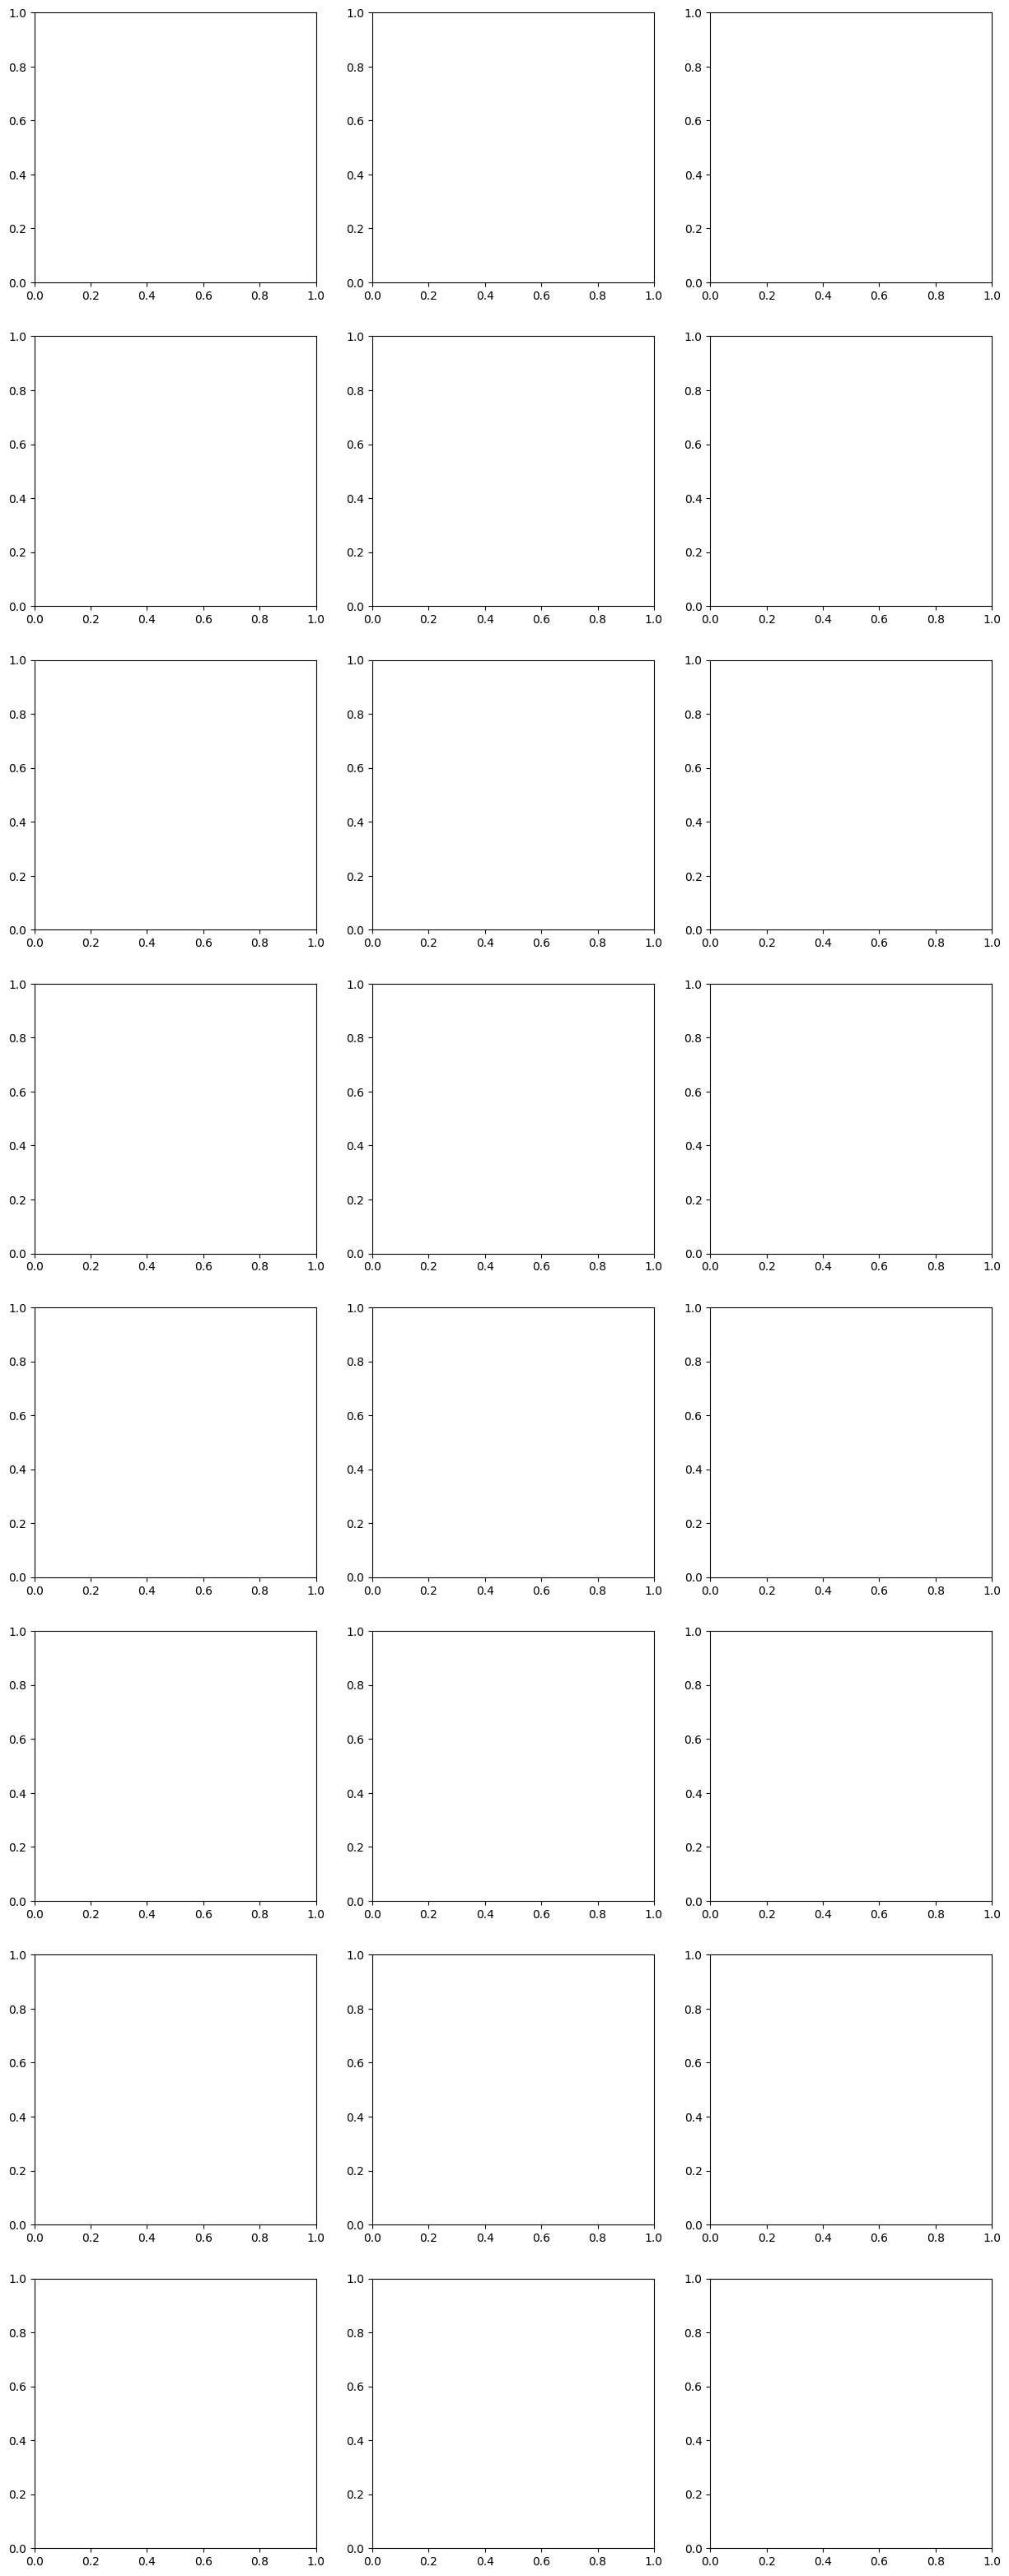

In [36]:
fig, axes = plt.subplots(N_SAMPLES, 3, figsize=(15, N_SAMPLES * 5))

if N_SAMPLES == 1:
    axes = axes.reshape(1, -1)

for i, idx in enumerate(selected_indices):
    img_path, mask_path = valid_pairs[idx]
    
    # Load data
    img, img_tensor = load_and_preprocess_image(img_path)
    gt_mask = load_mask(mask_path)
    
    # Predict
    pred_mask = predict(model, img_tensor, device)
    
    # Convert to colored
    gt_colored = apply_color_map(gt_mask, CLASS_COLORS)
    pred_colored = apply_color_map(pred_mask, CLASS_COLORS)
    
    # Plot
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'Original: {img_path.name}', fontsize=10)
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(gt_colored)
    axes[i, 1].set_title('Ground Truth', fontsize=10)
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(pred_colored)
    axes[i, 2].set_title('Prediction', fontsize=10)
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('/root/workspace/unet/viz_sidebyside.png', dpi=150, bbox_inches='tight')
plt.show()

print('Side-by-side visualization saved!')

## 5. Visualization Format 2: Overlay with Transparency

NameError: name 'mask_paths' is not defined

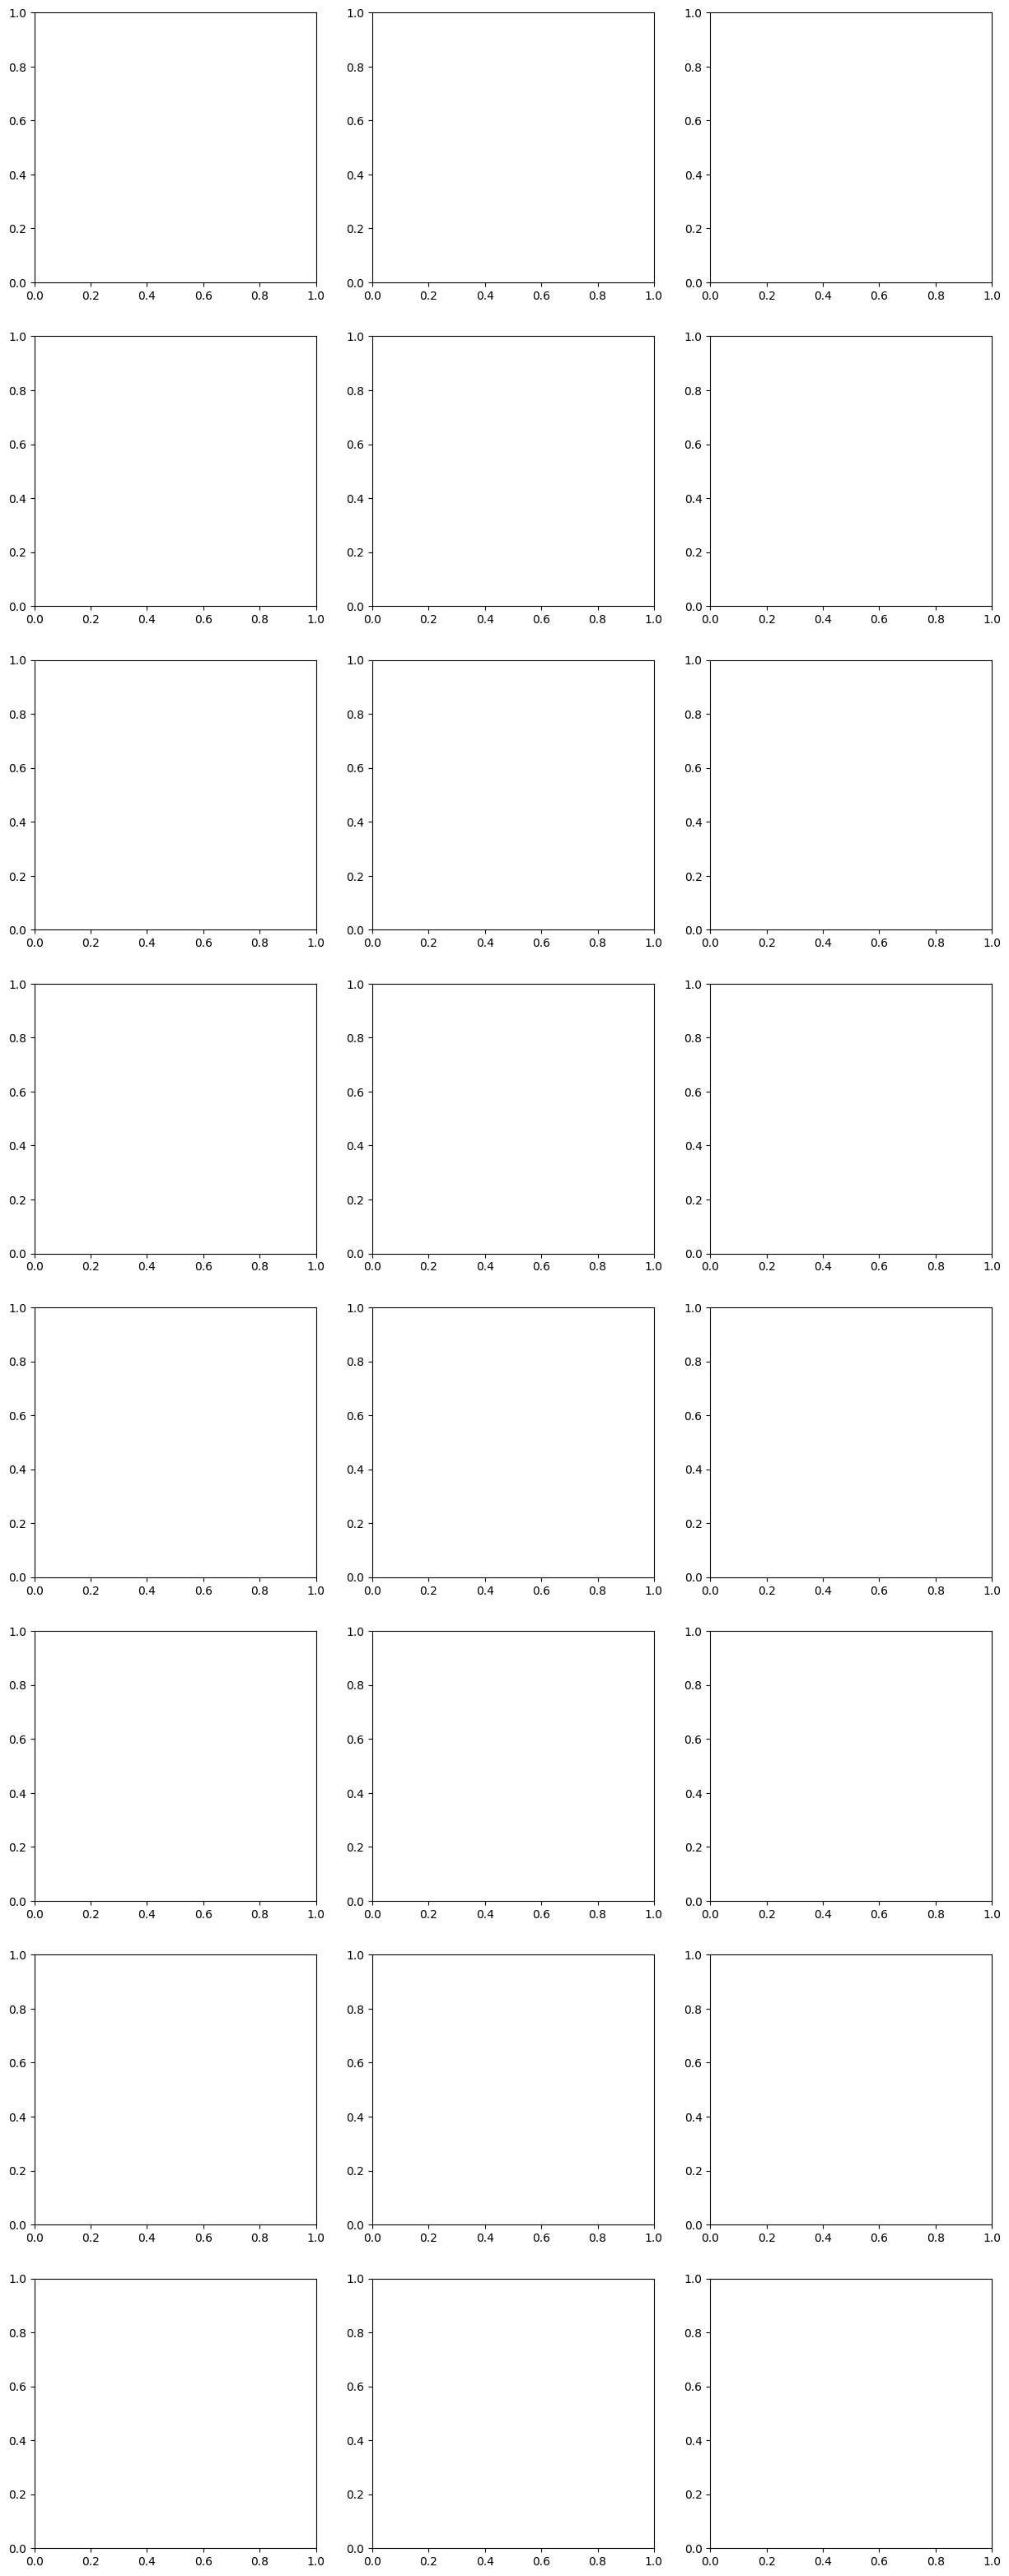

In [ ]:
fig, axes = plt.subplots(N_SAMPLES, 3, figsize=(15, N_SAMPLES * 5))

for i, idx in enumerate(selected_indices):
    img_path = image_paths[idx]
    mask_path = mask_paths[idx]
    
    # Load data
    img, img_tensor = load_and_preprocess_image(img_path)
    gt_mask = load_mask(mask_path)
    
    # Predict
    pred_mask = predict(model, img_tensor, device)
    
    # Create overlays
    gt_overlay = overlay_mask(img, gt_mask, CLASS_COLORS, alpha=0.5)
    pred_overlay = overlay_mask(img, pred_mask, CLASS_COLORS, alpha=0.5)
    
    # Plot
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'Original: {img_path.name}', fontsize=10)
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(gt_overlay)
    axes[i, 1].set_title('GT Overlay', fontsize=10)
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(pred_overlay)
    axes[i, 2].set_title('Prediction Overlay', fontsize=10)
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('/root/workspace/unet/viz_overlay.png', dpi=150, bbox_inches='tight')
plt.show()

print('Overlay visualization saved!')

## 6. Visualization Format 3: Comparison (Original | GT | Pred | GT Overlay | Pred Overlay)

In [ ]:
# Select 3 best examples
N_BEST = min(3, N_SAMPLES)

fig, axes = plt.subplots(N_BEST, 5, figsize=(20, N_BEST * 4))

if N_BEST == 1:
    axes = axes.reshape(1, -1)

for i in range(N_BEST):
    idx = selected_indices[i]
    img_path = image_paths[idx]
    mask_path = mask_paths[idx]
    
    # Load data
    img, img_tensor = load_and_preprocess_image(img_path)
    gt_mask = load_mask(mask_path)
    pred_mask = predict(model, img_tensor, device)
    
    # Convert and overlay
    gt_colored = apply_color_map(gt_mask, CLASS_COLORS)
    pred_colored = apply_color_map(pred_mask, CLASS_COLORS)
    gt_overlay = overlay_mask(img, gt_mask, CLASS_COLORS, alpha=0.5)
    pred_overlay = overlay_mask(img, pred_mask, CLASS_COLORS, alpha=0.5)
    
    # Plot all 5 versions
    axes[i, 0].imshow(img)
    axes[i, 0].set_title('Original', fontsize=12, fontweight='bold')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(gt_colored)
    axes[i, 1].set_title('GT Mask', fontsize=12, fontweight='bold')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(pred_colored)
    axes[i, 2].set_title('Pred Mask', fontsize=12, fontweight='bold')
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow(gt_overlay)
    axes[i, 3].set_title('GT Overlay', fontsize=12, fontweight='bold')
    axes[i, 3].axis('off')
    
    axes[i, 4].imshow(pred_overlay)
    axes[i, 4].set_title('Pred Overlay', fontsize=12, fontweight='bold')
    axes[i, 4].axis('off')

plt.tight_layout()
plt.savefig('/root/workspace/unet/viz_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print('Comparison visualization saved!')

## 7. Class Distribution Analysis

In [ ]:
# Calculate class statistics for one sample
idx = selected_indices[0]
img_path = image_paths[idx]
mask_path = mask_paths[idx]

img, img_tensor = load_and_preprocess_image(img_path)
gt_mask = load_mask(mask_path)
pred_mask = predict(model, img_tensor, device)

# Count pixels per class
gt_counts = [(gt_mask == i).sum() for i in range(len(CLASS_NAMES))]
pred_counts = [(pred_mask == i).sum() for i in range(len(CLASS_NAMES))]

# Plot bar chart
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(CLASS_NAMES))
width = 0.35

ax.bar(x - width/2, gt_counts, width, label='Ground Truth', alpha=0.8)
ax.bar(x + width/2, pred_counts, width, label='Prediction', alpha=0.8)

ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Pixel Count', fontsize=12, fontweight='bold')
ax.set_title(f'Class Distribution: {img_path.name}', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(CLASS_NAMES, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/root/workspace/unet/viz_class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print('Class distribution visualization saved!')

## 8. Summary

Visualizations saved:
- `viz_sidebyside.png` - Side-by-side comparison (Original | GT | Pred)
- `viz_overlay.png` - Transparent overlay visualization
- `viz_comparison.png` - Complete comparison (5 columns)
- `viz_class_distribution.png` - Class distribution bar chart

In [ ]:
print('\n✅ All visualizations completed!')
print(f'\nProcessed {N_SAMPLES} validation samples')
print(f'Model: {MODEL_PATH}')
print(f'Data: {DATA_DIR}')